In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)
import os
#os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'
import warnings

import sys
from pyprojroot import here
sys.path.append("..") 
from laos_gggi.statistics import get_distance_to_rivers

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr
import pytensor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage, create_floods_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY, LAOS_LOCATION_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Define helper functions

In [3]:
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset

#Redefine add data
def add_data(features: list[str], df: pd.DataFrame, 
             target: str | None = None, name = None, dims=None, dtype=None):
    X_name = 'X' if name is None else f'X_{name}'
    Y_name = 'Y' if name is None else f'Y_{name}'
    
    if dtype is None:
        dtype = pytensor.config.floatX
        
    with pm.modelcontext(None):
        X = pm.Data(X_name, df[features].astype(dtype), dims=dims)
        
        if target is not None:
            Y = pm.Data(Y_name, df[target].astype(dtype), dims=dims[0] if dims is not None else dims)
            return X, Y
        
    return X

In [4]:
# Function to create plot inputs
def generate_plot_inputs(target_variable: str, idata, disaster_type: str = "hydrological_disasters", df = pd.DataFrame ):
    #Extract predictions
    predictions = idata.posterior_predictive['damage'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(
                        columns = {"damage": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.damage)

    hdi = hdi_mean['damage'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.damage, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['damage'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[target_variable, "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "year", "damage"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"damage": "lower_damage_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO", "year", "damage"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"damage": "higher_damage_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "damage"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"damage": "lower_damage_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "damage"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"damage": "higher_damage_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"damage": "predictions"}))
    
    return df_predictions

In [5]:
#Plotting function
def plotting_function(idata, country: str, df: pd.DataFrame, target_variable: str):
    df_predictions = generate_plot_inputs(idata = idata, df = df, target_variable = target_variable)

    #Filter country
    data = df_predictions.query("ISO == @country")
    # data["damage_adjusted"] = (data["damage"])
    # cols_to_millions = ["predictions", "damage_adjusted", "higher_damage_95", "lower_damage_95", "lower_damage_50", "higher_damage_50"]
    # data[cols_to_millions] = data[cols_to_millions] /1e6
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"] , zorder=1000, color='tab:red', label=f'Mean  hydrometereological events damage')
    ax.scatter(data["year"], np.exp(data[target_variable].astype(float)) , color='k', label= ("Real hydrometereological events damage in millions of dollars"))
    ax.fill_between(data["year"], data["higher_damage_95"] , data["lower_damage_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_damage_50"], data["higher_damage_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("hydrometereological events damage in millions of dollars")
    
    plt.show();
    

In [6]:
def create_grid_from_shape(shapefile, rivers, coastline, grid_size = 100):
    long_min, lat_min, long_max, lat_max = shapefile.dissolve().bounds.values.ravel()
    long_grid = np.linspace(long_min, long_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)

    grid = np.column_stack([x.ravel() for x in np.meshgrid(long_grid, lat_grid)])
    grid = gpd.GeoSeries(gpd.points_from_xy(*grid.T), crs='EPSG:4326')
    grid = gpd.GeoDataFrame({'geometry': grid})

    point_overlay = grid.overlay(shapefile, how='intersection')
    points = point_overlay.geometry
    points = points.to_frame().assign(long = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)
    
    #Obtain distance with rivers
    distances_to_rivers = (get_distance_to(rivers, points=points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                           .rename(columns={'distance_to_closest':'distance_to_river'}))

    points = pd.merge(points, distances_to_rivers, left_index= True, right_index= True, how = "left")
    
    #Obtain Laos distance with coastlines
    distances_to_coastlines = (get_distance_to(coastline.boundary, points=points, return_columns=None)
                              .rename(columns={'distance_to_closest':'distance_to_coastline'}))

    points =  pd.merge(points, distances_to_coastlines, left_index= True, right_index= True, how = "left")
    
    #Create log of distances
    points = points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river),
                           log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline))
    
    if 'ISO_A3' in point_overlay.columns:
        points['ISO'] = point_overlay.ISO_A3
    else:
        points['ISO'] = 'LAO'
        
    return points

In [7]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [8]:
def compute_center(X):
    return (pt.max(X, axis=0) + pt.min(X, axis=0)).eval() / 2

# Importing and cleaning data

In [9]:
rep_df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()

#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_44896\2104074037.py:9: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


In [10]:
world = load_shapefile('world')
laos = load_shapefile('laos')

In [11]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


In [12]:
#Load river files
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

#Load Laos points
laos_points = pd.read_csv("../data/laos_points.csv")

In [13]:
#Floods damages and people_affected
damage_df_f = create_floods_rivers_damage()
damage_df_f = pd.merge(damage_df_f, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

#Create different "ORDFLOW" dummies
damage_df_f["ORD_FLOW_1"] = 0
for i in damage_df_f.index.values:
    if damage_df_f.loc[i, "ORD_FLOW"] == 1:
        damage_df_f.loc[i, "ORD_FLOW_1"] = 1

#Create the variable intrecation between closest river and ORD_FLOW
damage_df_f["closest_river_int_ORD_FLOW_1"] = damage_df_f["closest_river"] * damage_df_f["ORD_FLOW_1"]

In [14]:
#import disaster probability geospatial data
merged_df5 = pd.read_csv("../data/HSGP_full_model_data_hydro.csv")

C:\Users\camil\AppData\Local\Temp\ipykernel_44896\2620593457.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df5 = pd.read_csv("../data/HSGP_full_model_data_hydro.csv")


In [15]:
# Now I define the data set used to train the standardization pipeline
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline',
                'is_island', "lat", "long" ]


distance_features_2 = ['log_distance_to_river', 'log_distance_to_coastline', 'is_island']

time_varying_features_2 = ["Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_2 = merged_df5[model_list_2 + time_varying_features_2].dropna()

In [71]:
#Import economic and climate predictions for LAO
LAO_economic_predictions = pd.read_csv("../data/economic_forecasts.csv")
LAO_climate_predictions = pd.read_csv("../data/climate_forecasts.csv")

# Base models

## Base damage model

In [17]:
#Transform damage to millions
damage_df_f["log_Total_Damage_Adjusted"] = np.log(damage_df_f["Total_Damage_Adjusted_hydro"].replace({0.0: np.nan}))
damage_df_f["log_Total_Damage_Adjusted_millions"]  =  damage_df_f["log_Total_Damage_Adjusted"] -np.log(1e6)


In [18]:
#Homogenize variable names
variable_name_dict = {"ln_population_density":"log_population_density", 
 "ln_population_density_squared":"log_population_density_squared",
 "population":"Population",
 "ln_gdp_pc":"log_gdp_per_cap",
 "square_ln_gdp_pc":"log_gdp_per_cap_squared",
 "precip_deviation":"precip_deviation",
}

damage_df_f = damage_df_f.rename(columns = variable_name_dict)

In [19]:
#Set the columns to use
df_2 = damage_df_f[["log_population_density",  "Population",  "ISO",
                  "year" , "log_gdp_per_cap",
                    "log_Total_Damage_Adjusted", "log_Total_Damage_Adjusted_millions",
                 "precip_deviation", "co2"]].dropna()

In [192]:
#Define pipeline, standardize df and obtain the squared variables
cols_to_standardize = ["log_population_density",   "Population",
                       "log_gdp_per_cap", "precip_deviation", "co2"]

cols_to_square = ["log_population_density", "log_gdp_per_cap"]

pipeline_damages = ColumnTransformer([('standardize', StandardScaler(), cols_to_standardize),],
                            remainder='passthrough')
#train pipeline and standardize: 
df_2_stand = pd.DataFrame(pipeline_damages.fit_transform(df_2 ),
                          index=df_2.index,
                          columns=[x.split('__')[-1] for x in pipeline_damages.get_feature_names_out()])

#Square
df_2_stand["log_population_density_squared"] =df_2_stand["log_population_density"] **2

df_2_stand["log_gdp_per_cap_squared"] = df_2_stand["log_gdp_per_cap"] ** 2


In [193]:
damages_features = ["log_population_density", "Population",
                       "log_gdp_per_cap", "precip_deviation", "co2",
                   "log_population_density_squared", "log_gdp_per_cap_squared"]

In [194]:
#Set coords
ISO_2_idx, ISO_2 =  pd.factorize(df_2_stand["ISO"])
coords_damage = {
    'ISO':ISO_2,
    'obs_idx':df_2_stand.index,
    'feature': damages_features
        }    

xr_idx_damage = xr.Coordinates.from_pandas_multiindex(df_2_stand.set_index(['ISO', 'year']).index, 'obs_idx')

In [195]:
#Simple Damages model
with pm.Model(coords=coords_damage) as simple_damages_model:
    #Declare data
    X, Y= add_data(features= coords_damage["feature"] ,  target = "log_Total_Damage_Adjusted_millions", df = df_2_stand,
                  dims = ("obs_idx", "feature" ))
    
    #Country effectz
    country_effect = pm.Normal("country_effect", mu = 0, sigma =3, dims = ["ISO"])

    #Betas
    betas = pm.Normal("beta", mu = 0, sigma = 3, dims = ["feature"])

    #Model mu
    mu = country_effect[ISO_2_idx] + X @ betas

    #Sigma
    sigma = pm.Exponential('sigma', lam=1/10)

    log_damage = pm.Normal("log_damage", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])
    
    damage = pm.Deterministic('damage', pt.exp(log_damage), dims = ["obs_idx"])

In [196]:
#Sampling
with simple_damages_model:
    simple_damages_idata =sample_or_load(
            fp="simple_damages_model7_short",
            resample= True,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 4,
               #"target_accept": 0.9,
                "draws": 500,
            })

    simple_damages_idata = simple_damages_idata.assign_coords(xr_idx_damage)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [log_damage]


Output()

Output()

In [197]:
az.summary(simple_damages_idata, ["~country_effect", "~damage"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[log_population_density],0.564,0.483,-0.332,1.469,0.030,0.025,252.0,381.0,1.02
beta[Population],2.825,0.631,1.682,4.001,0.033,0.023,364.0,647.0,1.01
beta[log_gdp_per_cap],1.126,0.312,0.549,1.701,0.015,0.011,421.0,769.0,1.00
beta[precip_deviation],0.279,0.112,0.068,0.486,0.003,0.002,1714.0,1739.0,1.00
beta[co2],-0.079,0.109,-0.278,0.128,0.003,0.002,1174.0,1305.0,1.00
beta[log_population_density_squared],0.017,0.245,-0.451,0.451,0.014,0.010,313.0,481.0,1.01
beta[log_gdp_per_cap_squared],-0.183,0.213,-0.581,0.227,0.010,0.007,446.0,708.0,1.01
sigma,1.849,0.068,1.732,1.976,0.001,0.001,2134.0,1400.0,1.00


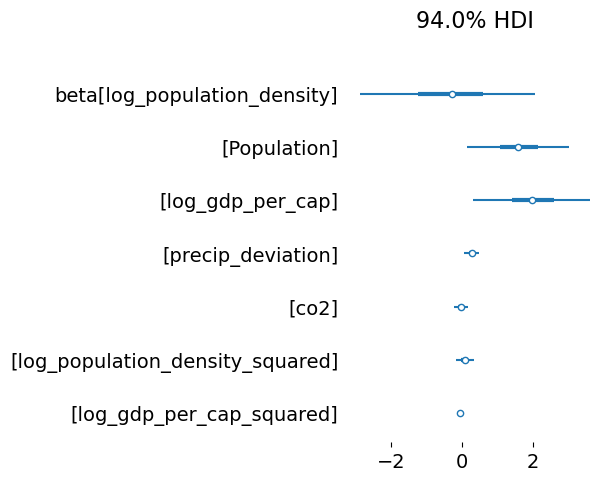

In [26]:
az.plot_forest(simple_damages_idata, var_names = ["~country_effect",
                                                  "~sigma", "~damage"], combined = True);

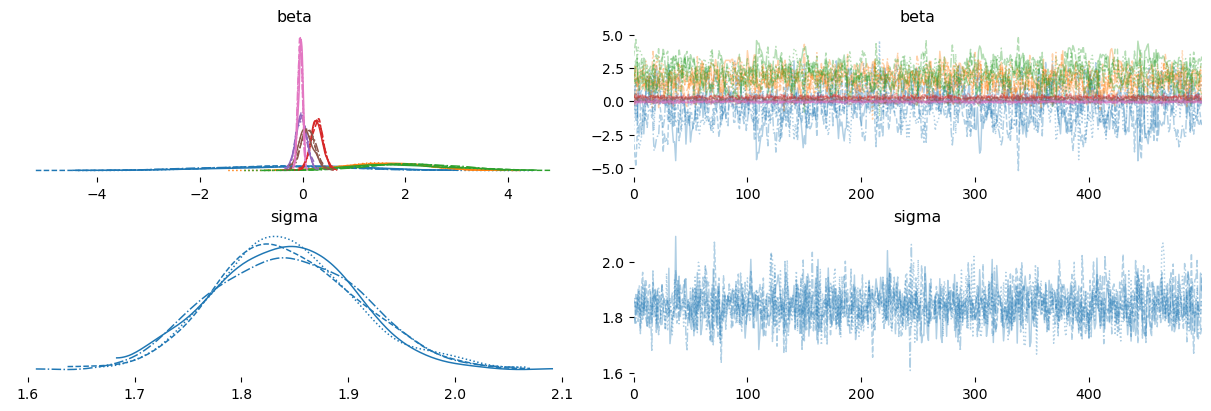

In [27]:
az.plot_trace(simple_damages_idata, var_names =  ["~country_effect", "~damage"]);

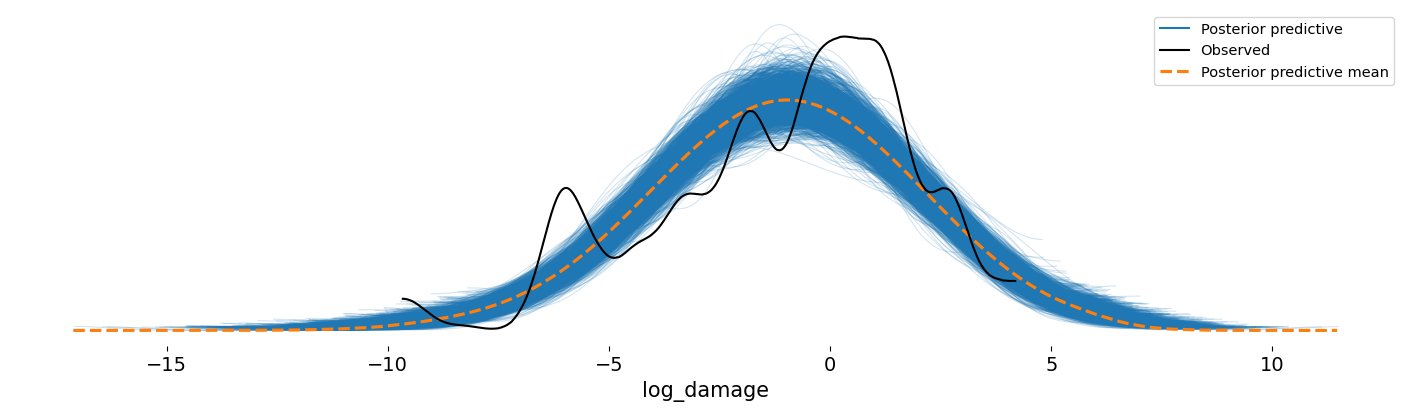

In [198]:
az.plot_ppc(simple_damages_idata);

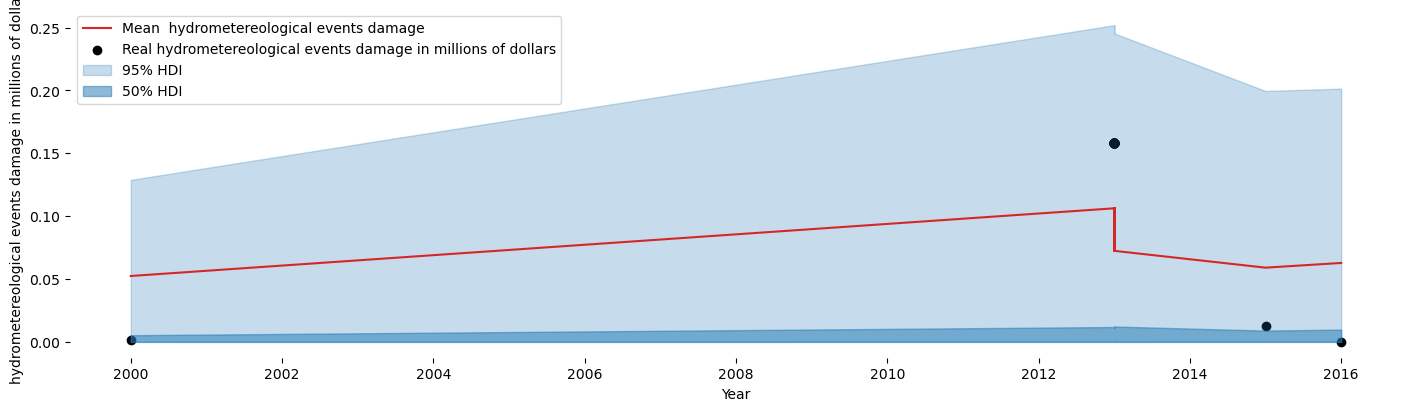

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotting_function(idata =simple_damages_idata , 
                      country = "LAO",
                      df = df_2_stand ,
                     target_variable= "log_Total_Damage_Adjusted_millions")

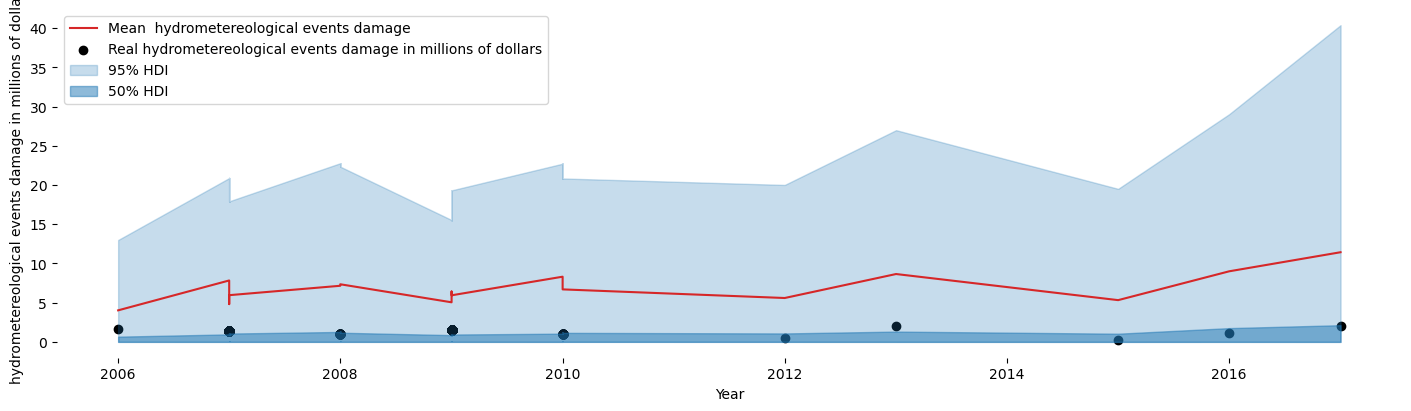

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotting_function(idata =simple_damages_idata , 
                      country = "VNM",
                      df = df_2_stand ,
                     target_variable= "log_Total_Damage_Adjusted_millions")

# Damage curves

### Join idatas

In [199]:
#Read idata 
floatX = pytensor.config.floatX
HSGP_full_model_idata = az.from_netcdf("../data/HSGP_full_model_idata.netcdf")

In [200]:
#Rename ISO dimension to avoid conflicts merging
simple_damages_idata =simple_damages_idata.rename({"ISO": "ISO_damage",
                                                   "country_effect": "country_effect_damage"})

In [201]:
#Merge posteriors
merged_posteriors = xr.merge([HSGP_full_model_idata.sel(ISO = coords_predictions["ISO"]).posterior,
                              simple_damages_idata.posterior])

### Set data for events model

In [202]:
#Define the used fd
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline',
                'is_island', "lat", "long" ]


distance_features_2 = ['log_distance_to_river', 'log_distance_to_coastline', 'is_island']

time_varying_features_2 = ["Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density','log_gdp_per_cap']

events_df = merged_df5[model_list_2 + time_varying_features_2].dropna()

In [203]:
#Define pipeline, standardize df and obtain the squared variables
cols_to_standardize = distance_features_2 + time_varying_features_2

cols_to_square = ["log_population_density", "log_gdp_per_cap"]

pipeline_events = ColumnTransformer([('standardize', StandardScaler(), cols_to_standardize),
                                     ('square', PolynomialFeatures(degree= (2,2), include_bias= False, ),cols_to_square)],
                            remainder='passthrough')
#train pipeline and standardize: 
events_df_stand = pd.DataFrame(pipeline_events.fit_transform(events_df),
                          index=events_df.index,
                          columns=[x.split('__')[-1] for x in pipeline_events.get_feature_names_out()])

#Rename
events_df_stand.rename( columns = {"log_population_density^2": "log_population_density_squared",
                             "log_gdp_per_cap^2": "log_gdp_per_cap_squared"}, inplace = True)

In [204]:
#Define general disaster cooords
isa_disaster_idx , is_disaster = pd.factorize(events_df_stand["is_disaster"])
ISO_idx, ISO = pd.factorize(events_df_stand["ISO"]) 
LAOS_idx = ISO.tolist().index("LAO")
obs_idx = events_df_stand.index
gp_features = ["lat", "long"]


event_features = ["log_population_density", "log_population_density_squared", "Population" , 
                       "log_gdp_per_cap", "log_gdp_per_cap_squared", "precip_deviation", "co2" ]

#Creating idx
xr_idx_events = xr.Coordinates.from_pandas_multiindex(events_df_stand.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_predictions = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "distance_features": distance_features_2,
        "time_varying_features" : time_varying_features_2,
        "gp_feature":gp_features,
        "ISO_damage": coords_damage["ISO"],
        "new_damage_features": event_features,
        "year":events_df_stand["Start_Year"].unique()
                     }

### Select points for prediction

Define the points, country and year for the curve construction

In [205]:
#Prepare point for predictions
points_df = pd.DataFrame({'Vientiane': {'lat': 17.9757, 'long': 102.6331},
                            'Luang Prabang': {'lat': 19.8860, 'long': 102.1350},
                            'Savannakhet': {'lat': 16.5575, 'long': 104.7528},
                            'Pakse': {'lat': 15.1202, 'long': 105.7987},
                            'Thakhek': {'lat': 17.4106, 'long': 104.8304},
                        }).transpose().reset_index().rename(columns = {"index": "city"})


points_df_geo =  gpd.GeoDataFrame(
                points_df, geometry=gpd.points_from_xy(points_df["long"], points_df["lat"]), crs="EPSG:4326"
            )


#Get distances
log_point_distance_rivers = np.log(get_distance_to(rivers.boundary, points=points_df_geo, return_columns=None)
                              .rename(columns={'distance_to_closest':'log_distance_to_river'}))

log_point_distance_coastlines  = np.log(get_distance_to(coastline.boundary, points=points_df_geo, return_columns=None)
                              .rename(columns={'distance_to_closest':'log_distance_to_coastline'}))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [206]:
#Merge distances
point_distance_data =  pd.merge(log_point_distance_rivers, log_point_distance_coastlines,
                                left_index=True, right_index= True, how= "inner")

point_distance_data["is_island"] = False
point_distance_data.rename(columns = { "log_distance_to_river": "log_distance_to_river",
                                     }, inplace = True)

In [207]:
#standardize distances
distances_to_standardize  = ["log_distance_to_river", "log_distance_to_coastline" ]

pipeline_distances = ColumnTransformer([('standardize', StandardScaler(), distances_to_standardize)],
                            remainder='passthrough')

In [208]:
events_distances_stand = pd.DataFrame(pipeline_distances.fit_transform(events_df[distances_to_standardize]),
                          index=events_df[distances_to_standardize].index.values ,
                          columns=[x.split('__')[-1] for x in pipeline_distances.get_feature_names_out()])

In [209]:
point_distance_data_stand = pd.DataFrame(pipeline_distances.transform(point_distance_data),
                          index=point_distance_data.index,
                          columns=[x.split('__')[-1] for x in pipeline_distances.get_feature_names_out()])

In [210]:
#merge point data
final_point_df =  pd.concat([points_df_geo, point_distance_data_stand], axis =1 ).reset_index()

final_point_df["is_island"] = False

Now we add the climate and economic predictions

In [211]:
LAO_climate_predictions_req   = LAO_climate_predictions[["time", "co2", "Temp", "LAO_precip_deviation",]].copy()
LAO_economic_predictions_req = LAO_economic_predictions[["LAO_log_population","LAO_log_gdp",
                                                         "LAO_log_gdp_pc" , "ln_population_density", "Population", "time"]].copy()

In [213]:
#Adjust ocean temp
from statsmodels.tsa.seasonal import STL

stl_ocean_temp = STL(pd.DataFrame(LAO_climate_predictions_req["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend

LAO_climate_predictions_req["Temp"] = LAO_climate_predictions_req["Temp"].dropna() - trend_ocean_temp

In [214]:
LAO_economic_predictions_req.rename(columns = {"ln_population_density":"log_population_density",
                                           "LAO_log_gdp_pc": "log_gdp_per_cap", }, inplace= True)

LAO_climate_predictions_req.rename(columns = {"LAO_precip_deviation": "precip_deviation",
                                                                    "Temp": "dev_ocean_temp",
                                                                   }, inplace = True)

Lao_prediction_inputs  = pd.merge(LAO_climate_predictions_req,LAO_economic_predictions_req, 
                                  left_on= "time", right_on="time", how= "left"  )
Lao_prediction_inputs = Lao_prediction_inputs[(time_varying_features_2 + ["time"]) ]
Lao_prediction_inputs = Lao_prediction_inputs.dropna()
Lao_prediction_inputs.rename(columns = {"time": "Start_Year"}, inplace= True)

In [215]:
#Standardize predictions

#Train the pipeline on training data
#Define pipeline

cols_to_square = ["log_population_density", "log_gdp_per_cap"]

pipeline_predictions = ColumnTransformer([('standardize', StandardScaler(), time_varying_features_2)],
                                        remainder='passthrough')

event_model_data_varying = pd.DataFrame(pipeline_predictions.fit_transform(events_df[time_varying_features_2 + ["Start_Year"]] ),
                          index=events_df[time_varying_features_2].index,
                          columns=[x.split('__')[-1] for x in pipeline_predictions.get_feature_names_out()])
#Standardize
Lao_prediction_inputs_stand = pd.DataFrame(pipeline_predictions.transform(Lao_prediction_inputs ),
                          index=Lao_prediction_inputs[time_varying_features_2].index,
                          columns=[x.split('__')[-1] for x in pipeline_predictions.get_feature_names_out()])

Lao_prediction_inputs_stand["log_population_density_squared"] =Lao_prediction_inputs_stand["log_population_density"] **2

Lao_prediction_inputs_stand["log_gdp_per_cap_squared"] = Lao_prediction_inputs_stand["log_gdp_per_cap"] ** 2


In [216]:
#Combine all the data
target_df = pd.DataFrame()

for x in (years_to_predict):
    temp = final_point_df.copy()
    temp["Start_Year"] = x
    temp = pd.merge(temp, Lao_prediction_inputs_stand, left_on= "Start_Year", right_on= "Start_Year", 
                                  how = "left" )
    target_df= pd.concat([target_df, temp], axis = 0 )

target_df.reset_index(inplace= True, drop= True)
target_df.drop(columns = ["index"], inplace= True)

In [218]:
coords_predictions["time_varying_features"] =  (time_varying_features_2 +
                                                ["log_gdp_per_cap_squared", "log_population_density_squared"])

### Predictions

Now we run the predictions

In [232]:
target_df.set_index(["city", "Start_Year"]).index

MultiIndex([(    'Vientiane', '2024-01-01'),
            ('Luang Prabang', '2024-01-01'),
            (  'Savannakhet', '2024-01-01'),
            (        'Pakse', '2024-01-01'),
            (      'Thakhek', '2024-01-01'),
            (    'Vientiane', '2025-01-01'),
            ('Luang Prabang', '2025-01-01'),
            (  'Savannakhet', '2025-01-01'),
            (        'Pakse', '2025-01-01'),
            (      'Thakhek', '2025-01-01'),
            (    'Vientiane', '2026-01-01'),
            ('Luang Prabang', '2026-01-01'),
            (  'Savannakhet', '2026-01-01'),
            (        'Pakse', '2026-01-01'),
            (      'Thakhek', '2026-01-01')],
           names=['city', 'Start_Year'])

In [233]:
# First we run 
#Point prediction
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
coords_predictions['obs_idx'] = target_df.index.values
coords_predictions["time_varying_features"] =  (time_varying_features_2 +
                                                ["log_gdp_per_cap_squared", "log_population_density_squared"])
idx = xr.Coordinates.from_pandas_multiindex(target_df.set_index(["city", "Start_Year"]).index, "obs_idx" )


with pm.Model(coords=coords_predictions) as damage_curves_plot:
    ####################################Events model####################################
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  target_df, dims=['obs_idx', 'features'])
    economic_data = add_data(features = coords_predictions["time_varying_features"] ,  target = None, df =  target_df,
                             name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", target_df[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])

    #Flat variables
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # HSGP component
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(events_df[['lat', 'long']].values.astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[LAOS_idx] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    event_prob = pm.Deterministic('event_prob', pm.math.invlogit(logit_p), dims=['obs_idx'])

    ####################################Damages model####################################
    damage_x_data = pm.Data("damage_x_data",  target_df[coords_predictions["new_damage_features"]], dims=['obs_idx', 'new_damage_features'])
    country_effect_damage = pm.Flat("country_effect_damage", dims = ["ISO_damage"])
    beta = pm.Flat("beta", dims = ["new_damage_features"])
    sigma = pm.Flat("sigma")

    #mu and damage
    mu =  country_effect_damage[63] + damage_x_data @ beta
    predicted_log_damage = pm.Normal("predicted_log_damage", mu = mu, sigma = sigma , dims = ["obs_idx"])
    
    predicted_damages = pm.Deterministic("predicted_damages", pm.math.exp(predicted_log_damage), dims=['obs_idx'])

    damages_curves = pm.Deterministic("damages_curves", predicted_damages * event_prob, dims=['obs_idx'])
    
with freeze_dims_and_data(damage_curves_plot):
    idata_plot_point = pm.sample_posterior_predictive(merged_posteriors , extend_inferencedata=False, 
                                                      compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 
                                                           'geographic_component', 
                                                           'economic_component', 
                                                           'logit_p', 
                                                           'event_prob', 
                                                           "predicted_log_damage", "predicted_damages", 
                                                           "damages_curves"
                                                          ])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x18A92A13AE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [predicted_log_damage]


Output()

In [234]:
damage_curves = idata_plot_point.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

In [236]:
idata_plot_point = idata_plot_point.assign_coords(idx)

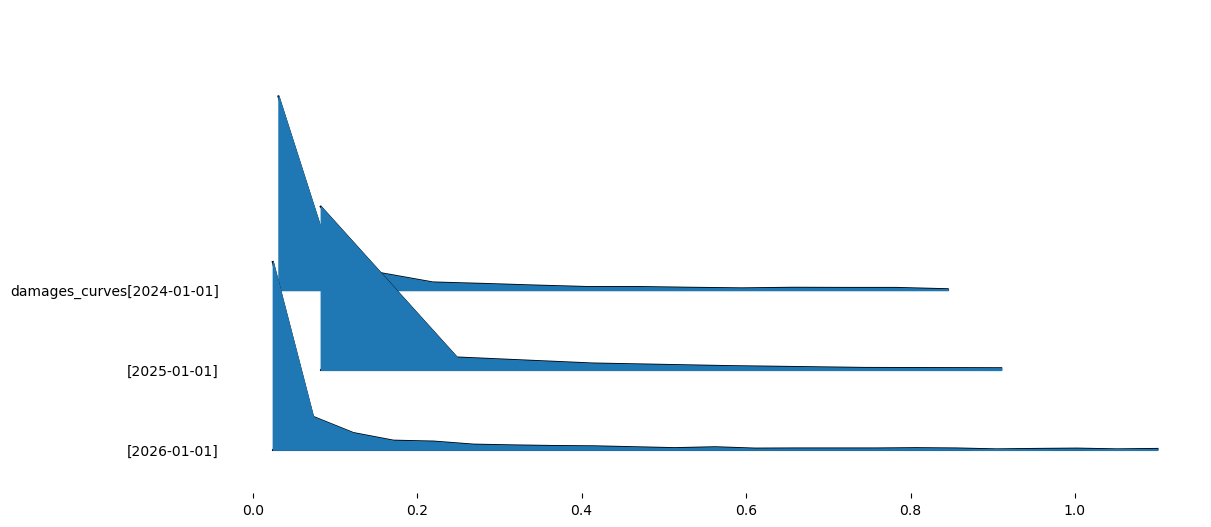

In [239]:
az.plot_forest(idata_plot_point.posterior_predictive.sel(city = "Vientiane" ), var_names= ["damages_curves"], 
               combined= True, kind= "ridgeplot");

In [228]:
damage_curves

,HSGP_component,damages_curves,economic_component,event_prob,geographic_component,logit_p,predicted_damages,predicted_log_damage
obs_idx,,,,,,,,
0,-0.059205,0.276065,0.129568,0.112778,-3.946054,-2.618389,2.752226,-1.033507
1,-0.037418,0.323739,0.129568,0.124642,-3.830068,-2.480616,2.587985,-1.123616
2,0.277887,0.561244,0.129568,0.169310,-3.696297,-2.031540,3.582755,-1.095893
3,0.274238,0.670635,0.129568,0.176553,-3.636386,-1.975278,3.305463,-1.109764
4,0.023757,0.471832,0.129568,0.150260,-3.626969,-2.216342,3.011952,-1.077865
5,-0.059205,0.350045,0.131972,0.113002,-3.946054,-2.615985,3.543380,-1.047407
6,-0.037418,0.407380,0.131972,0.124885,-3.830068,-2.478212,3.470138,-1.105419
7,0.277887,0.753654,0.131972,0.169614,-3.696297,-2.029136,3.817047,-1.026915
8,0.274238,0.452153,0.131972,0.176865,-3.636386,-1.972874,2.566930,-1.133703
